In [1]:
!pip install torchmetrics


     |████████████████████████████████| 332 kB 11.1 MB/s 


In [2]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics import F1
from torchmetrics.functional import accuracy, precision, recall

##Загружаем и препроцессим дату

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_pos = pd.read_csv('/content/drive/MyDrive/nn_methods_data/positive.csv', encoding='utf-8', sep=';', header=None)
data_neg = pd.read_csv('/content/drive/MyDrive/nn_methods_data/negative.csv', encoding='utf-8', sep=';', header=None)

data_pos['value'] = [1 for i in range(len(data_pos))]
data_neg['value'] = [0 for i in range(len(data_neg))]

data = pd.concat([data_pos, data_neg])

data = data.drop(columns=[col for col in data.columns if col != 3 and col != 'value'])
data = data.rename(columns={3: 'text'})



In [5]:
data.head()

,text,value
0,"@first_timee хоть я и школота, но поверь, у на...",1
1,"Да, все-таки он немного похож на него. Но мой ...",1
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1
4,@irina_dyshkant Вот что значит страшилка :D\nН...,1


In [6]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = ' '.join([token.strip(punctuation) for token in tokens])
    return tokens



In [7]:
data['text'] = data['text'].apply(preprocess)

In [8]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data.head()

,text,value
107097,немного выпьем говорил он ничего не будет гово...,1
109252,я по твоему общению и шуткам соскучилась че-то...,0
63992,sergey_mladshiy ахахаахх....как ты мою собаку ...,1
108549,"dasha_0305 daria2709 лично мне,было вообще по ...",1
67962,наташа реальный китаец пишет что не хера не по...,1


In [9]:
vocab = Counter()

for text in data['text']:
    vocab.update(text.split())

filtered_vocab = set()

for word in vocab:
    if vocab[word] > 2:
        filtered_vocab.add(word)
print('уникальных токенов, втретившихся больше 2 раз:', len(filtered_vocab))

уникальных токенов, втретившихся больше 2 раз: 64422


In [10]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [11]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

##Датасеты и даталоадеры для 1 модели


In [ ]:
class DataDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['value'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = self.dataset[index]
        ids = torch.LongTensor([self.word2id[word] for word in words.split() if word in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch):
        ids, y = list(zip(*batch))
        padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_ids, y

In [ ]:
train_dataset = DataDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

batch = next(iter(train_iterator))
batch[0].shape

torch.Size([1024, 28])

In [ ]:
test_dataset = DataDataset(test_data, word2id, DEVICE)
test_sampler = SequentialSampler(test_dataset)
test_iterator = DataLoader(test_dataset, collate_fn = test_dataset.collate_fn, sampler=test_sampler, batch_size=1024)

test_batch = next(iter(test_iterator))
test_batch[0].shape

torch.Size([1024, 25])

##Модель 1, эмбеддинг слой внутри модели

In [ ]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim) #эмбеддинг слой, embed_dim -  корень из вокаб_сайз

        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same') #свертки с разным окном
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.conv = nn.Conv1d(in_channels=180, out_channels=100, kernel_size=3, padding='same')

        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=100, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        #batch_size x seq_len   1024 23
        embedded = self.embedding(word)
        #batch_size x seq_len x embedding_dim  1024 23 embedding_dim (256)
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len  1024 256 23

        conv2 = self.relu(self.bigrams(embedded))
        #batch_size x out_channels x seq_len  1024 100 23
        conv3 = self.relu(self.trigrams(embedded))
        #batch_size x out_channels x seq_len  1024 80 23

        concat = torch.cat((conv2, conv3), 1)
        #batch_size x (out_channels+out_channels) x seq_len  1024 180 23

        conv_over_concat = self.relu(self.conv(concat))
        #batch_size x out_channels x seq_len  1024 100 23

        pooling_over_time = conv_over_concat.max(2)[0] 
        #batch_size x out_channels 1024 100

        logits = self.hidden(pooling_over_time) 
        logits = self.out(logits)      
        return logits

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(texts)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
    print(f'Train loss: {epoch_loss/ (len(iterator))}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_precision = 0
    epoch_recall = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_accuracy = accuracy(preds.round().long(), ys.long(), ignore_index=0)
            batch_precision = precision(preds.round().long(), ys.long(), ignore_index=0)
            batch_recall = recall(preds.round().long(), ys.long(), ignore_index=0)

            epoch_accuracy += batch_accuracy
            epoch_precision += batch_precision
            epoch_recall += batch_recall
        print(f'Val loss: {epoch_loss / (i + 1)}, Val Accuracy: {epoch_accuracy / (i + 1)}, Val Precision: {epoch_precision / (i + 1)}, Val Recall: {epoch_recall / (i + 1)}')
        
    return epoch_accuracy / len(iterator), epoch_precision / len(iterator), epoch_recall / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [ ]:
EMBED_SIZE = 8 
model = CNN(len(word2id), EMBED_SIZE)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
def loop(epoch, model, train_iterator, test_iterator, optimizer, criterion):
    losses = []
    losses_eval = []
    acc = []
    acc_eval = []

    for i in range(epoch):
        print(f'\nstarting Epoch {i}')
        print('Training...')
        epoch_loss = train(model, train_iterator, optimizer, criterion)
        losses.append(epoch_loss)
        print('\nEvaluating on train...')
        acc_on_train, pr_on_train, rec_on_train, _ = evaluate(model, train_iterator, criterion)
        acc.append(acc_on_train)
        print('\nEvaluating on test...')
        acc_on_test, pr_on_test, rec_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion)
        losses_eval.append(epoch_loss_on_test)
        acc_eval.append(acc_on_test)
    return losses, losses_eval, acc, acc_eval, model

In [ ]:
epoches = 15
losses, losses_eval, acc, acc_eval, model = loop(epoches, model, train_iterator, test_iterator, optimizer, criterion)


starting Epoch 0
Training...
Train loss: 0.6716861460316047

Evaluating on train...
Val loss: 0.6523132478253225, Val Accuracy: 0.6115415692329407, Val Precision: 0.6218485236167908, Val Recall: 0.6115415692329407

Evaluating on test...
Val loss: 0.6552579482396443, Val Accuracy: 0.6023300886154175, Val Precision: 0.6160098314285278, Val Recall: 0.6023300886154175

starting Epoch 1
Training...
Train loss: 0.6422294766715403

Evaluating on train...
Val loss: 0.6272070314107316, Val Accuracy: 0.7173596024513245, Val Precision: 0.6277834177017212, Val Recall: 0.7173596024513245

Evaluating on test...
Val loss: 0.6351812415652804, Val Accuracy: 0.7047449350357056, Val Precision: 0.6170549988746643, Val Recall: 0.7047449350357056

starting Epoch 2
Training...
Train loss: 0.6197440513734067

Evaluating on train...
Val loss: 0.6059984243317936, Val Accuracy: 0.735859215259552, Val Precision: 0.645725667476654, Val Recall: 0.735859215259552

Evaluating on test...
Val loss: 0.6193417376942105,

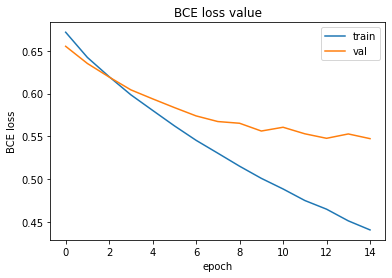

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

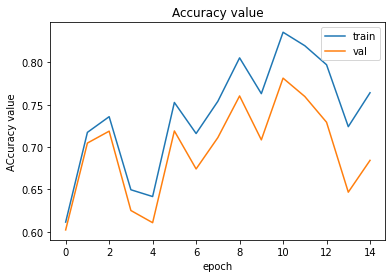

In [ ]:
import matplotlib.pyplot as plt
plt.plot(acc)
plt.plot(acc_eval)
plt.title('Accuracy value')
plt.ylabel('ACcuracy value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Видно, что модель моментально переобучается, - качество на трэине неизменно растет (модель просто запоминает паттерны), а на тесте начинает падать. 

## Модель 1 с эмбеддинг слоем - эксперименты

In [ ]:
class CNN_exp(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim) #эмбеддинг слой, embed_dim -  корень из вокаб_сайз

        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=64, kernel_size=2, padding='same') #свертки с разным окном
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=48, kernel_size=3, padding='same')
        self.conv = nn.Conv1d(in_channels=112, out_channels=100, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=100, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        #batch_size x seq_len   1024 23
        embedded = self.embedding(word)
        #batch_size x seq_len x embedding_dim  1024 23 embedding_dim (256)
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len  1024 256 23

        conv2 = self.dropout(self.relu(self.bigrams(embedded)))
        #batch_size x out_channels x seq_len  1024 100 11
        conv3 = self.dropout(self.relu(self.trigrams(embedded)))
        #batch_size x out_channels x seq_len  1024 80 11

        concat = torch.cat((conv2, conv3), 1) 
        #batch_size x (out_channels+out_channels) x seq_len  1024 180 23

        conv_over_concat = self.dropout(self.relu(self.conv(concat)))
        #batch_size x out_channels x seq_len  1024 100 23

        pooling_over_time = conv_over_concat.max(2)[0] 
        #batch_size x out_channels 1024 100

        logits = self.hidden(pooling_over_time) 
        logits = self.out(logits)      
        return logits

In [ ]:
EMBED_SIZE = 256
model = CNN_exp(len(word2id), EMBED_SIZE)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
epoches = 15
losses, losses_eval, acc, acc_eval, model = loop(epoches, model, train_iterator, test_iterator, optimizer, criterion)


starting Epoch 0
Training...
Train loss: 0.6417944126584557

Evaluating on train...
Val loss: 0.6053433418273926, Val Accuracy: 0.7327567338943481, Val Precision: 0.6634098291397095, Val Recall: 0.7327567338943481

Evaluating on test...
Val loss: 0.6097554789649116, Val Accuracy: 0.7222697138786316, Val Precision: 0.6518329977989197, Val Recall: 0.7222697138786316

starting Epoch 1
Training...
Train loss: 0.582107909274905

Evaluating on train...
Val loss: 0.5660948321390687, Val Accuracy: 0.7391247749328613, Val Precision: 0.7193282842636108, Val Recall: 0.7391247749328613

Evaluating on test...
Val loss: 0.5775839818848504, Val Accuracy: 0.7194954752922058, Val Precision: 0.6983302235603333, Val Recall: 0.7194954752922058

starting Epoch 2
Training...
Train loss: 0.542247894774662

Evaluating on train...
Val loss: 0.532969206571579, Val Accuracy: 0.7489508986473083, Val Precision: 0.7582015991210938, Val Recall: 0.7489508986473083

Evaluating on test...
Val loss: 0.5529609680175781,

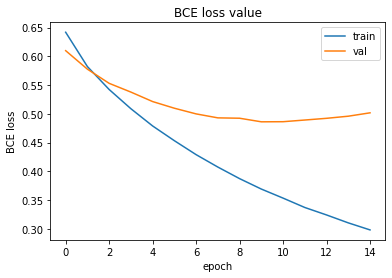

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

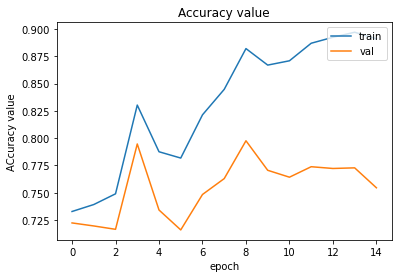

In [ ]:
import matplotlib.pyplot as plt
plt.plot(acc)
plt.plot(acc_eval)
plt.title('Accuracy value')
plt.ylabel('ACcuracy value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Качество чуть выше и модель не так сильно переобучается. Я добавила дропаут слои и изменила размер эмбеддингов, а также уменьшила количество фильтров

## Модель 1 с предобученным эмбеддингами fasttext

In [12]:
import gensim
from gensim.models import KeyedVectors

In [13]:
fast_text_file = '/content/drive/MyDrive/araneum_none_fasttextcbow_300_5_2018.model'
model_fasttext = gensim.models.KeyedVectors.load(fast_text_file)

In [ ]:
weights = np.zeros((len(word2id), 300))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = model_fasttext[word]   
    except:
      count += 1
      # oov словам сопоставляем случайный вектор
      weights[i] = np.random.normal(0,0.1,300)

In [ ]:
class CNN_fasttext(nn.Module):
    
    def __init__(self, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 300) #эмбеддинг слой, embed_dim -  корень из вокаб_сайз
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)

        self.bigrams = nn.Conv1d(in_channels=300, out_channels=64, kernel_size=2, padding='same') #свертки с разным окном
        self.trigrams = nn.Conv1d(in_channels=300, out_channels=48, kernel_size=3, padding='same')
        self.conv = nn.Conv1d(in_channels=112, out_channels=100, kernel_size=3, padding='same')

        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=100, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        #batch_size x seq_len   1024 23
        embedded = self.embedding(word)
        #batch_size x seq_len x embedding_dim  1024 23 embedding_dim (256)
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len  1024 256 23

        conv2 = self.dropout(self.relu(self.bigrams(embedded)))
        #batch_size x out_channels x seq_len  1024 100 11
        conv3 = self.dropout(self.relu(self.trigrams(embedded)))
        #batch_size x out_channels x seq_len  1024 80 11

        concat = torch.cat((conv2, conv3), 1) 
        #batch_size x (out_channels+out_channels) x seq_len  1024 180 23

        conv_over_concat = self.dropout(self.relu(self.conv(concat)))
        #batch_size x out_channels x seq_len  1024 100 23

        pooling_over_time = conv_over_concat.max(2)[0] 
        #batch_size x out_channels 1024 100

        logits = self.hidden(pooling_over_time) 
        logits = self.out(logits)      
        return logits

In [ ]:
model = CNN_fasttext(len(word2id))
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss() # Binary Cross Entropy

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
epoches = 15
losses, losses_eval, acc, acc_eval, model = loop(epoches, model, train_iterator, test_iterator, optimizer, criterion)


starting Epoch 0
Training...
Train loss: 0.6376800614126613

Evaluating on train...
Val loss: 0.5981826705209324, Val Accuracy: 0.66744065284729, Val Precision: 0.6960664391517639, Val Recall: 0.66744065284729

Evaluating on test...
Val loss: 0.602730561627282, Val Accuracy: 0.6555835604667664, Val Precision: 0.6848910450935364, Val Recall: 0.6555835604667664

starting Epoch 1
Training...
Train loss: 0.5765018108185758

Evaluating on train...
Val loss: 0.557931271161926, Val Accuracy: 0.7122153043746948, Val Precision: 0.7418900728225708, Val Recall: 0.7122153043746948

Evaluating on test...
Val loss: 0.5703009711371527, Val Accuracy: 0.6904422640800476, Val Precision: 0.7199532389640808, Val Recall: 0.6904422640800476

starting Epoch 2
Training...
Train loss: 0.5339657309350003

Evaluating on train...
Val loss: 0.5237477485383495, Val Accuracy: 0.7237632870674133, Val Precision: 0.7859438061714172, Val Recall: 0.7237632870674133

Evaluating on test...
Val loss: 0.5465083811018202, Va

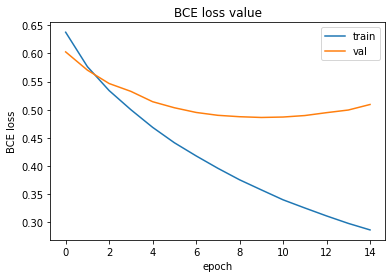

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

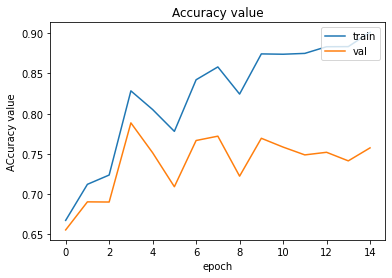

In [ ]:
import matplotlib.pyplot as plt
plt.plot(acc)
plt.plot(acc_eval)
plt.title('Accuracy value')
plt.ylabel('ACcuracy value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Датасеты и даталоадеры для 2 модели


In [14]:
vocab = Counter()
for symbol in data['text']:
    vocab.update(list(' '.join(preprocess(symbol))))
print('всего уникальных символов:', len(vocab))

всего уникальных символов: 381


In [15]:
filtered_vocab = set()

for symbol in vocab:
    if vocab[symbol] > 5:
        filtered_vocab.add(symbol)
print('уникальных символов, втретившихся больше 5 раз:', len(filtered_vocab))

уникальных символов, втретившихся больше 5 раз: 164


In [16]:
symbol2id = {'PAD':0}

for symbol in filtered_vocab:
    symbol2id[symbol] = len(symbol2id)

id2symbol = {i:symbol for symbol, i in symbol2id.items()}

In [17]:
class DataDataset2(Dataset):

    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = dataset['value'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = self.dataset[index]
        symbols = list(self.dataset[index])
        ids_words = torch.LongTensor([self.word2id[word] for word in words.split() if word in self.word2id])
        ids_symbols =  ids = torch.LongTensor([self.symbol2id[symbol] for symbol in symbols if symbol in self.symbol2id])
        y = [self.target[index]]
        return ids_words, ids_symbols, y

    def collate_fn(self, batch):
        ids_words, ids_symbols, y = list(zip(*batch))
        padded_ids_words = pad_sequence(ids_words, batch_first=True).to(self.device)
        padded_ids_symbols = pad_sequence(ids_symbols, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_ids_words, padded_ids_symbols, y

In [18]:
train_dataset = DataDataset2(train_data, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

batch = next(iter(train_iterator))
batch[0].shape, batch[1].shape

(torch.Size([1024, 27]), torch.Size([1024, 143]))

In [19]:
test_dataset = DataDataset2(test_data, word2id, symbol2id, DEVICE)
test_sampler = SequentialSampler(test_dataset)
test_iterator = DataLoader(test_dataset, collate_fn = test_dataset.collate_fn, sampler=test_sampler, batch_size=1024)

test_batch = next(iter(test_iterator))
test_batch[0].shape, test_batch[1].shape

(torch.Size([1024, 25]), torch.Size([1024, 139]))

In [20]:
weights = np.zeros((len(word2id), 300))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = model_fasttext[word]   
    except:
      count += 1
      # oov словам сопоставляем случайный вектор
      weights[i] = np.random.normal(0,0.1,300)

## Модель 2

In [22]:
class CNN_words_symbols(nn.Module):
    
    def __init__(self, vocab_size):
        super().__init__()
        self.embedding_words = nn.Embedding(vocab_size, 300) #эмбеддинг слой, embed_dim -  корень из вокаб_сайз
        self.embedding_words.from_pretrained(torch.tensor(weights), freeze=True)

        self.embedding_symbols = nn.Embedding(vocab_size, 6)

        self.words_layer = nn.Linear(300, 20)    

        self.conv_2 = nn.Conv1d(in_channels=6, out_channels=100, kernel_size=2, padding='same') #свертки с разным окном
        self.conv_3 = nn.Conv1d(in_channels=6, out_channels=80, kernel_size=3, padding='same')

        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=200, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word, symb):
        #batch_size x seq_len   1024 23
        embedded_words = self.embedding_words(word)   #1024  seqlen  300
        mean_emb_sent = torch.mean(embedded_words, dim=1)   #1024 300
        X = self.words_layer(mean_emb_sent)   #1024  128

        embedded_symb = self.embedding_symbols(symb)  #1024 charlen 8
        embedded_symb = embedded_symb.transpose(1,2)
        #batch_size x embedding_dim x seq_len  1024 8 charlen

        conv2 = self.relu(self.conv_2(embedded_symb))  #1024  64 charlen
        conv3 = self.relu(self.conv_3(embedded_symb))    #1024  48 charlen

        concat_conv = torch.cat((conv2, conv3), 1) 
        
        #batch_size x (out_channels+out_channels) x seq_len  1024 112 23
        pooling_over_time = concat_conv.max(2)[0] 
        #batch_size x out_channels 1024 112

        concat_words_symbols = torch.cat((X, pooling_over_time), 1) #1024 240

        logits = self.hidden(concat_words_symbols) 
        logits = self.out(logits)      
        return logits

In [23]:
def train_2(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (words, symbols, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(words, symbols)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
    print(f'Train loss: {epoch_loss/ (len(iterator))}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

In [24]:
def evaluate_2(model, iterator, criterion):
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_precision = 0
    epoch_recall = 0
    model.eval() 
    with torch.no_grad():
        for i, (words, symbols, ys) in enumerate(iterator):   
            preds = model(words, symbols)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_accuracy = accuracy(preds.round().long(), ys.long(), ignore_index=0)
            batch_precision = precision(preds.round().long(), ys.long(), ignore_index=0)
            batch_recall = recall(preds.round().long(), ys.long(), ignore_index=0)

            epoch_accuracy += batch_accuracy
            epoch_precision += batch_precision
            epoch_recall += batch_recall
        print(f'Val loss: {epoch_loss / (i + 1)}, Val Accuracy: {epoch_accuracy / (i + 1)}, Val Precision: {epoch_precision / (i + 1)}, Val Recall: {epoch_recall / (i + 1)}')
        
    return epoch_accuracy / len(iterator), epoch_precision / len(iterator), epoch_recall / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [25]:
def loop_2(epoch, model, train_iterator, test_iterator, optimizer, criterion, scheduler=None):
    losses = []
    losses_eval = []
    acc = []
    acc_eval = []

    for i in range(epoch):
        print(f'\nstarting Epoch {i}')
        print('Training...')
        epoch_loss = train_2(model, train_iterator, optimizer, criterion)
        if scheduler:
            scheduler.step()
        losses.append(epoch_loss)
        print('\nEvaluating on train...')
        acc_on_train, pr_on_train, rec_on_train, _ = evaluate_2(model, train_iterator, criterion)
        acc.append(acc_on_train)
        print('\nEvaluating on test...')
        acc_on_test, pr_on_test, rec_on_test, epoch_loss_on_test = evaluate_2(model, test_iterator, criterion)
        losses_eval.append(epoch_loss_on_test)
        acc_eval.append(acc_on_test)
    return losses, losses_eval, acc, acc_eval, model

In [26]:
model = CNN_words_symbols(len(word2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [27]:
epoches = 10
losses, losses_eval, acc, acc_eval, model = loop_2(epoches, model, train_iterator, test_iterator, optimizer, criterion)


starting Epoch 0
Training...


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)


Train loss: 0.6667316746845674

Evaluating on train...
Val loss: 0.6160342462277144, Val Accuracy: 0.6842480301856995, Val Precision: 0.6613747477531433, Val Recall: 0.6842480301856995

Evaluating on test...
Val loss: 0.6190503809187148, Val Accuracy: 0.6798823475837708, Val Precision: 0.6530532836914062, Val Recall: 0.6798823475837708

starting Epoch 1
Training...
Train loss: 0.5592210498753558

Evaluating on train...
Val loss: 0.4983025117871467, Val Accuracy: 0.8103905916213989, Val Precision: 0.7400751709938049, Val Recall: 0.8103905916213989

Evaluating on test...
Val loss: 0.5246642053127288, Val Accuracy: 0.7906840443611145, Val Precision: 0.7169402241706848, Val Recall: 0.7906840443611145

starting Epoch 2
Training...
Train loss: 0.4730336277672414

Evaluating on train...
Val loss: 0.4452101867855265, Val Accuracy: 0.700471043586731, Val Precision: 0.8614426851272583, Val Recall: 0.700471043586731

Evaluating on test...
Val loss: 0.5011497769090865, Val Accuracy: 0.655500054359

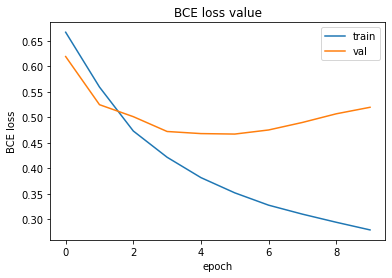

In [28]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

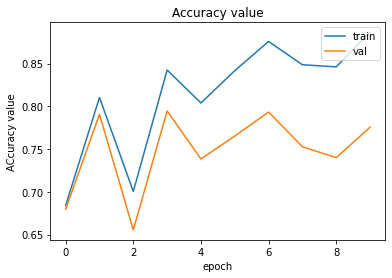

In [29]:
import matplotlib.pyplot as plt
plt.plot(acc)
plt.plot(acc_eval)
plt.title('Accuracy value')
plt.ylabel('ACcuracy value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Видно, что переобучается модель.

## Модель 2 эксперименты

In [30]:
class CNN_words_symbols_exp(nn.Module):
    
    def __init__(self, vocab_size):
        super().__init__()
        self.embedding_words = nn.Embedding(vocab_size, 300) #эмбеддинг слой, embed_dim -  корень из вокаб_сайз
        self.embedding_words.from_pretrained(torch.tensor(weights), freeze=True)

        self.embedding_symbols = nn.Embedding(vocab_size, 16)

        self.words_layer = nn.Linear(300, 120)    


        self.conv_2 = nn.Conv1d(in_channels=16, out_channels=80, kernel_size=2, padding='same') #свертки с разным окном
        self.conv_3 = nn.Conv1d(in_channels=16, out_channels=60, kernel_size=3, padding='same')

        self.relu = nn.ReLU()
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.hidden = nn.Linear(in_features=260, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word, symb):
        #batch_size x seq_len   1024 23
        embedded_words = self.embedding_words(word)   #1024  seqlen  300
        mean_emb_sent = torch.mean(embedded_words, dim=1)   #1024 300
        X = self.words_layer(mean_emb_sent)   #1024  128

        embedded_symb = self.embedding_symbols(symb)  #1024 charlen 8
        embedded_symb = embedded_symb.transpose(1,2)
        #batch_size x embedding_dim x seq_len  1024 8 charlen

        conv2 = self.relu(self.conv_2(embedded_symb))  #1024  64 charlen
        conv3 = self.relu(self.conv_3(embedded_symb))    #1024  48 charlen

        concat_conv = torch.cat((conv2, conv3), 1) 
        #batch_size x (out_channels+out_channels) x seq_len  1024 112 23

        pooling_over_time = concat_conv.max(2)[0] 
        #batch_size x out_channels 1024 112

        concat_words_symbols = torch.cat((X, pooling_over_time), 1) #1024 240

        logits = self.hidden(concat_words_symbols)


        logits = self.out(logits)      
        return logits

In [31]:
model = CNN_words_symbols_exp(len(word2id))
optimizer = optim.Adam(model.parameters(), lr=0.0005)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
criterion = nn.BCELoss()  
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [32]:
epoches = 10
losses, losses_eval, acc, acc_eval, model = loop_2(epoches, model, train_iterator, test_iterator, optimizer, criterion, scheduler)


starting Epoch 0
Training...
Train loss: 0.640865518805686

Evaluating on train...
Val loss: 0.591725117369984, Val Accuracy: 0.7310280203819275, Val Precision: 0.6793076395988464, Val Recall: 0.7310280203819275

Evaluating on test...
Val loss: 0.5942693021562364, Val Accuracy: 0.7271637916564941, Val Precision: 0.6721987724304199, Val Recall: 0.7271637916564941

starting Epoch 1
Training...
Train loss: 0.5604609816931607

Evaluating on train...
Val loss: 0.5233598641130361, Val Accuracy: 0.7676772475242615, Val Precision: 0.7330241799354553, Val Recall: 0.7676772475242615

Evaluating on test...
Val loss: 0.5363391240437826, Val Accuracy: 0.7567475438117981, Val Precision: 0.7216513156890869, Val Recall: 0.7567475438117981

starting Epoch 2
Training...
Train loss: 0.5055147103044424

Evaluating on train...
Val loss: 0.47854775793096993, Val Accuracy: 0.7487108111381531, Val Precision: 0.7906384468078613, Val Recall: 0.7487108111381531

Evaluating on test...
Val loss: 0.504431519243452

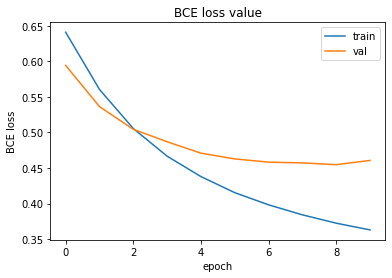

In [33]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

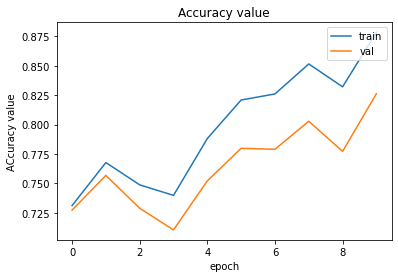

In [34]:
import matplotlib.pyplot as plt
plt.plot(acc)
plt.plot(acc_eval)
plt.title('Accuracy value')
plt.ylabel('ACcuracy value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

модель меньше переобучается и качество чуть выше, я немного поменяла параметры в модели (размер эмбеддингов, выходных каналов в фильтрах и количество выходных нейронов в линейном слое), а так же добавила регуляцию lr (scheduler).

##Анализ ошибок

In [38]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (words, symbols, ys) in enumerate(iterator):   
            preds = model(words, symbols)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, symbols):
              text = ''.join([id2symbol[int(symbol)] for symbol in text if symbol !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    return fp, fn, tp, tn

In [39]:
fp, fn, tp, tn = predict(model, test_iterator)

In [45]:
tp[:50]  #то, что позитивно и мы предсказываем позитивно

['у меня какой-то особенный вид ушей d некоторые вакуумные наушники в моих ушах просто не держатся',
 'rt darina_lo домааааа ехали на такси пели песни отдыхали кричали на улице мы настоящяя семья',
 'лежим с молой в постели  помогаем ему выбирать машину ',
 'я вас найду отрежу пальцы и заставлю сожрать если еще раз добавите меня в общую беседу вконтакте с какой-то левой херней чмоки лавки ',
 'larkagerasimova контоев артем рост вес и тд интересует ',
 'rt orymbasar erkesh04 пхахахах хорщая мать бля:d',
 'пока нету моего психолопсихотерапевта и его заместителя можно поиздеваться над собой а потом выслушивать от заместителя крики на меня ',
 'rt sail_or_moon посмотрела путь лидера эмоции зашкаливают',
 'el_grenade simoncowell ахахаа пальцы не сломай смотри',
 'снова таким лохматым не буду ещё долго http://t.co/bjdd2ktusq',
 'juliarezgal чем сильнее хочешь тем быстрее будет агааа',
 'yurid1231 baba_yaga_blya volkova_v честно говоря я и так счастлив',
 'подумал о варианте  себ и rb не доми

In [51]:
fp[:50]  #то, что предсказываем позитивно, а оно негативно

['simonovkon он неплохой человек в жизни я работала в шоу-бизе со многими знакома встречаются очень хорошие люди и не очень',
 'завтра с женой выезжаем домой  посли завтра платить за аренду ',
 'vasilkov диагностику пока не сделаю комп свой хондовский спалил',
 'ура я не спал всю ночь а все потому что мне надо практику переписать видите ли  ненааавииижу',
 'вообще-то я гаечка — я не знал http://t.co/ucvf7fg3bj',
 'дочитала мастер и маргарита"...впечатление осталось сложное даже часть не поняла',
 'rt sherikbatirhan vafodorxuja gulnarakarimova ilovegoogoosha а меня на днях уже взломали  http://t.co/bdynhoudod',
 'дебиановский метапакет libvdpau-driver сцуко битый ',
 'gasymovafidana вообще пиздец,щас собака его доела',
 'пошел учить два стиха и сочинение писать  http://t.co/tahammmitd',
 'пленку надо проявлять вовремя из 3 катушек на 36 в живых осталось 4 кадра ',
 'rt bobuk последний radiot  начинается прямо сейчас http://t.co/ne2r2tb4ig',
 'надо сказать это было не легко  ff follow',


In [52]:
fn[:50] #то, что позитивно, а мы говорим, что негативно

['rt miwisakovab не грустим за летом скоро будет следующее',
 'sceoms а у меня десятый час только  только проснулась',
 'rt an9_tripytina такой неудачный день надеюсь неделя такой не будет',
 'pom_pom_bom я про завал что задают слишком много хотя,я уже знаю ответ на этот вопрос лол ибо у меня так же',
 'm_galustyan я сделала оливье и ощущение нового года сразу появилось',
 'rt wilalusapyvo он ездил мне по ушам,потом я проколола ему колеса и запаски у него не оказалось',
 'а ведь все мы не любим вопрос как дела на личке когда точно знаем что никак ',
 '12tanyusha пляши,я завтра дома развлекать меня будешь ',
 'я просто иногда хочу какой-то поддержки и понимания.но иди я нахуй с такими требованиями ',
 'бляха муха...сходила к бабуле с дедулей и объелась чувствую,что неделю не буду есть',
 'nikolaibaskov avanesyanelmira на жизнь,творчество и любовь денег не жалко дай бог что бы и впредь было так ',
 'бедная девушка промоутер:dсаня ну почему после того шока,что она пережила ты не взял ее з

- во-первых, очень много твитов, которым я бы не смогла однозначно приписать отметку
позитив или негатив, поэтому неудивительно, что машина с ними то справляется, то нет (предсказание рандомное - вероятность угадывается 50 на 50).
- во-вторых, видно, что некоторую отрицательную лексику, которая помогает однозначно определить тональность, модель не детектит
например, "убил", "ненавижу", ненормативная лексика, отсюда тоже ошибки есть
- также есть некоторые твитты с позитивной лексикой типа "отличный", "самые любимые" в негативных твиттах. неудивительно, что модель на таких случаях ошибается 
- то же самое и относится к негативной лексике в позитивных твиттах: "неудачный", ненормативная лексика. Отсюда тоже часто ошибки
- также не понял, что некоторые темы сами по себе негативны, например, про майдан и украину
- никнеймы пользователей или ссылки не несут никакой нужной для решения этой задачи информации, возможно, они лишь путают модель